## Utils

In [67]:
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

ts = True
try:
    from torchsummary import summary
except:
    ts = False
    print("Not found torchsummary, please install it.")

os.environ["WANDB_SILENT"] = "true"
    

In [68]:
train_ratio = 0.7
val_ratio = 0.15
# test_ratio = 0.2

# train_ratio = 0.8
# val_ratio = 0.2

max_epochs = 40
batch_size = 32
num_workers = 4
wandb_log = False
graphing = False
hyperparameter_tuning = False

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
def wandb_init(lr, max_epochs, architecture, batch_size, dropout):
    if wandb_log:
        config = {
            "lr": lr, 
            "architecture": architecture,
            "model_type": "CNN",
            "optimizer": "Adam",
            "criterion": "cross_entropy",
            "num_epochs": max_epochs,
            "batch_size": batch_size,
            "dropout": dropout,
            # "gpu_id": 0,
            "wandb_run_name": "bhav" ,
            "tags": ["P4",]
        }

        wandb.init(entity = "bhavberi",   # wandb username. (NOT REQUIRED ARG. ANYMORE, it fetches from initial login)
                project = "SMAI",        # wandb project name. New project will be created if given project is missing.
                config = config         # Config dict
                )
        wandb.run.name = f"P4_{config['architecture']}_{config['lr']}_{config['batch_size']}_{config['num_epochs']}_{config['dropout']}"
        print(wandb.run.name)

def wandb_finish():
    if wandb_log:
        wandb.finish()

In [71]:
class BaselineNet(nn.Module):
    def __init__(self, dropout=0.5):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(64 * 5 * 5, 128)
        # self.fc2 = nn.Linear(128, 10)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x))) # 16 * 13 * 13
        x = self.pool2(torch.relu(self.conv2(x))) # 32 * 5 * 5
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        # x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            x = torch.argmax(x, dim=1)
        return x

In [72]:
class Net1(nn.Module):
    def __init__(self, dropout=0.5):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 16 * 13 * 13
        x = self.pool(torch.relu(self.conv2(x))) # 32 * 5 * 5
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            x = torch.argmax(x, dim=1)
        return x

In [73]:
class Net2(nn.Module):
    def __init__(self, dropout=0.5):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 12 * 12
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 4 * 4
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            x = torch.argmax(x, dim=1)
        return x

In [74]:
class Net3(nn.Module):
    def __init__(self, dropout=0.5):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 14 * 14
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 7 * 7
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            x = torch.argmax(x, dim=1)
        return x

In [75]:
def get_layers(model):
    layers = dict()
    for name, layer in model.named_children():
        layers[name] = layer
    return layers

In [76]:
def visualize_feature_maps(model, layer_name, input_image):
    model.eval()

    target_layer = None
    for name, layer in model.named_modules():
        # print(name)
        if name == layer_name:
            target_layer = layer
    
    if target_layer is None:
        raise ValueError(f"Layer {layer_name} not found in the model.")
    
    def hook(module, input, output):
        global feature_maps
        feature_maps = output.detach().cpu()

    hook_handle = target_layer.register_forward_hook(hook)
    with torch.no_grad():
        model(input_image.to(device))
    
    hook_handle.remove()

    # with torch.no_grad():
    #     feature_maps = target_layer(input_image.unsqueeze(0).to(device)).squeeze()

    print(f"Shape of feature maps: {feature_maps.size()}")

    num_feature_maps = feature_maps.size(0)
    feature_map_size = feature_maps.size(1)
    num_rows = num_feature_maps // 8  # Arrange the feature maps in rows of 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(16, 2 * num_rows))

    for i in range(num_feature_maps):
        row = i // 8
        col = i % 8
        ax = axes[row, col]
        ax.imshow(feature_maps[i].cpu(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")

    # Hide any remaining empty subplots
    for i in range(num_feature_maps, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    fig.suptitle(f"Feature Maps of Layer {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [77]:
def train(model, max_epochs, save_model=None, graph=False, wandb_log=False, print_every = 100):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(max_epochs):
        running_loss = 0.0
        epoch_less = 0
        no_test = 0
        accuracy = 0
        
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_less += loss.item()
            no_test += len(labels)
            accuracy += (outputs.argmax(dim=1) == labels).float().sum().item()
            
            if print_every and (i + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        train_losses.append(epoch_less / len(train_loader))
        train_acc.append(accuracy / no_test)

        # Validation
        model.eval()
        epoch_loss = 0
        no_val = 0
        accuracy = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                accuracy += (outputs.argmax(dim=1) == labels).float().sum().item()
                no_val += len(labels)
        val_losses.append(epoch_loss / len(val_loader))
        val_acc.append(accuracy / no_val)

        if print_every:
            print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}")

        if wandb_log:
            wandb.log({"epoch": epoch + 1, "train_loss": train_losses[-1], "val_loss": val_losses[-1], "train_acc": train_acc[-1], "val_acc": val_acc[-1]})

    if print_every:
        print("Finished Training")

    if save_model is not None:
        torch.save(model.state_dict(), save_model)
        print(f"Saved PyTorch Model State to {save_model}")
    
    if graph:
        plt.figure(figsize=(12, 8))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(train_acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        plt.show()

    return train_losses, val_losses, train_acc, val_acc


In [12]:
def test(model, test_loader, print_acc=True, per_class=False, classification=False, confusion=False, misclassified=False):
    model.eval()

    correct = 0
    total = 0

    predictions = []
    gt = []
    misclassified_examples = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.tolist())
            gt.extend(labels.tolist())

            predicted = predicted.tolist()
            labels = labels.tolist()

            if misclassified:
                for i in range(len(labels)):
                    if len(misclassified_examples) == 5:
                        break
                    if labels[i] != predicted[i]:
                        misclassified_examples.append((inputs[i].cpu().numpy(), labels[i], predicted[i]))

    accuracy = 100 * correct / total
    if print_acc:
        print(f"Accuracy on the test dataset: {accuracy:.2f}%")

    if per_class:
        per_class_correct = [0] * 10
        per_class_total = [0] * 10

        for i in range(len(gt)):
            class_id = gt[i]
            if predictions[i] == class_id:
                per_class_correct[class_id] += 1
            per_class_total[class_id] += 1

        for class_id in range(10):
            class_accuracy = (per_class_correct[class_id] / per_class_total[class_id]) * 100
            print(f"Accuracy for class {class_id}: {class_accuracy:.2f}%")
    
    class_names = [str(i) for i in range(10)]
    classification_rep = classification_report(gt, predictions, target_names=class_names)
    if classification:
        print(classification_rep)
    
    if confusion:
        conf_matrix = confusion_matrix(gt, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    if misclassified:
        return accuracy, misclassified_examples
    
    return accuracy

## Main Code

#### 4.1 & 4.2

In [13]:
model = BaselineNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
get_layers(model)

{'conv1': Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 'pool1': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'conv2': Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
 'pool2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'fc1': Linear(in_features=800, out_features=10, bias=True),
 'dropout': Dropout(p=0.5, inplace=False),
 'softmax': Softmax(dim=1)}

In [15]:
if ts:
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         MaxPool2d-2           [-1, 16, 13, 13]               0
            Conv2d-3           [-1, 32, 11, 11]           4,640
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                   [-1, 10]           8,010
           Dropout-6                   [-1, 10]               0
           Softmax-7                   [-1, 10]               0
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.05
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [16]:
dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True)

dataset_size = len(dataset)
print('Number of images: ', dataset_size)

Number of images:  60000


6742 5421 Difference: 1321


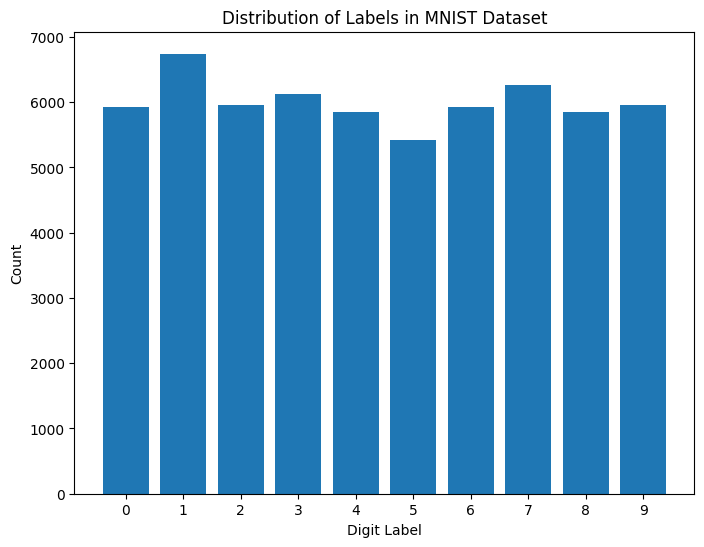

In [17]:
labels = dataset.targets.numpy()
label_counts = np.bincount(labels)

print(np.max(label_counts), np.min(label_counts), "Difference:", np.max(label_counts) - np.min(label_counts))

plt.figure(figsize=(8, 6))
plt.bar(range(10), label_counts, tick_label=np.arange(10))
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in MNIST Dataset")
plt.show()

> Class Imbalance

No, there doesn't seem to be any class imbalance as such (except a small one of around 10% at max) in the dataset. The dataset is fairly balanced, and can be used for training without any class imbalance issues.

In [18]:
samples_per_class = {label: [] for label in range(10)}

for i, (image, label) in enumerate(dataset):
    if len(samples_per_class[label]) < 5:
        samples_per_class[label].append(image)
    if all(len(samples) == 5 for samples in samples_per_class.values()):
        break

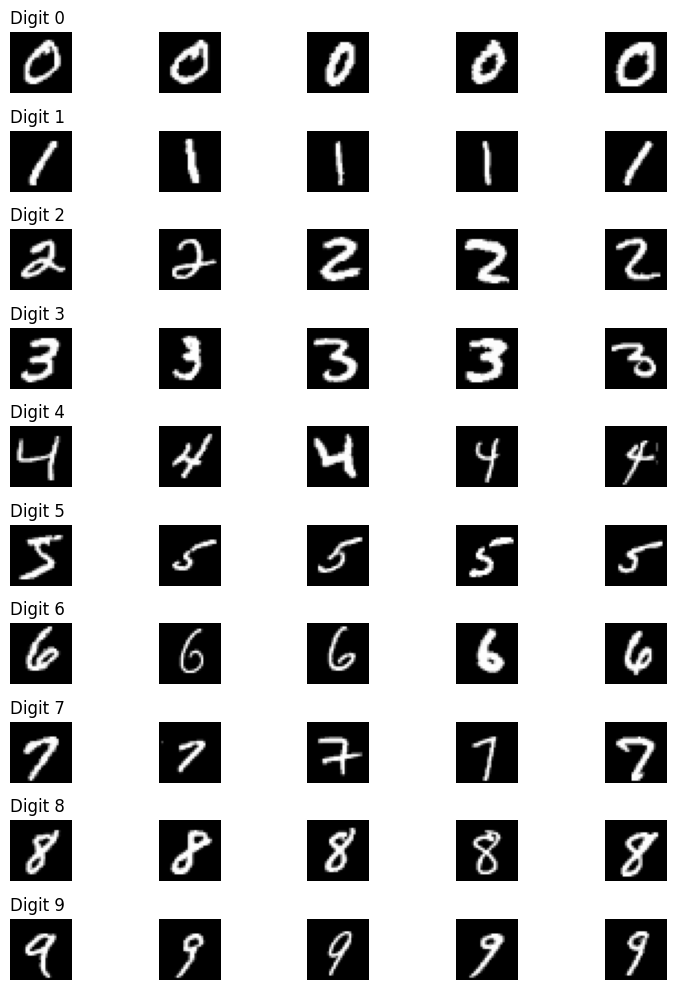

In [19]:
plt.figure(figsize=(8, 10))
for label, samples in samples_per_class.items():
    for i, sample in enumerate(samples):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Digit {label}', loc='left')
plt.tight_layout()
plt.show()

In [20]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# To put the data into a DataLoader, we need to convert it into a TensorDataset first

In [21]:
train_set, val_set, test_set = Data.random_split(
    train_dataset, [
        int(train_ratio * dataset_size),
        int(val_ratio * dataset_size),
        int((1 - train_ratio - val_ratio) * dataset_size)
    ]
)

train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
test_loader1 = Data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [110]:
train_losses, val_losses, train_acc, val_acc = train(model, max_epochs, "../models/baseline_model_mnist.pth", graph=graphing)

Epoch 1, Batch 100, Loss: 2.274
Epoch 1, Batch 200, Loss: 2.263
Epoch 1, Batch 300, Loss: 2.267
Epoch 1, Batch 400, Loss: 2.254
Epoch 1, Batch 500, Loss: 2.260
Epoch 1, Batch 600, Loss: 2.260
Epoch 1, Batch 700, Loss: 2.257
Epoch 1, Batch 800, Loss: 2.254
Epoch 1, Batch 900, Loss: 2.258
Epoch 1, Batch 1000, Loss: 2.259
Epoch 1, Batch 1100, Loss: 2.257
Epoch 1, Batch 1200, Loss: 2.259
Epoch 1, Batch 1300, Loss: 2.256
Epoch 1, Train Loss: 2.260, Val Loss: 2.221, Accuracy: 0.210
Epoch 2, Batch 100, Loss: 2.254
Epoch 2, Batch 200, Loss: 2.260
Epoch 2, Batch 300, Loss: 2.257
Epoch 2, Batch 400, Loss: 2.257
Epoch 2, Batch 500, Loss: 2.255
Epoch 2, Batch 600, Loss: 2.223
Epoch 2, Batch 700, Loss: 2.216
Epoch 2, Batch 800, Loss: 2.221
Epoch 2, Batch 900, Loss: 2.226
Epoch 2, Batch 1000, Loss: 2.223
Epoch 2, Batch 1100, Loss: 2.220
Epoch 2, Batch 1200, Loss: 2.225
Epoch 2, Batch 1300, Loss: 2.218
Epoch 2, Train Loss: 2.235, Val Loss: 2.146, Accuracy: 0.303
Epoch 3, Batch 100, Loss: 2.187
Epoch 

In [206]:
print("On Test Split Set")
test(model, test_loader)
print("On Test Set")
test(model, test_loader1)

On Test Split Set
Accuracy on the test dataset: 98.73%
On Test Set
Accuracy on the test dataset: 98.97%


98.97

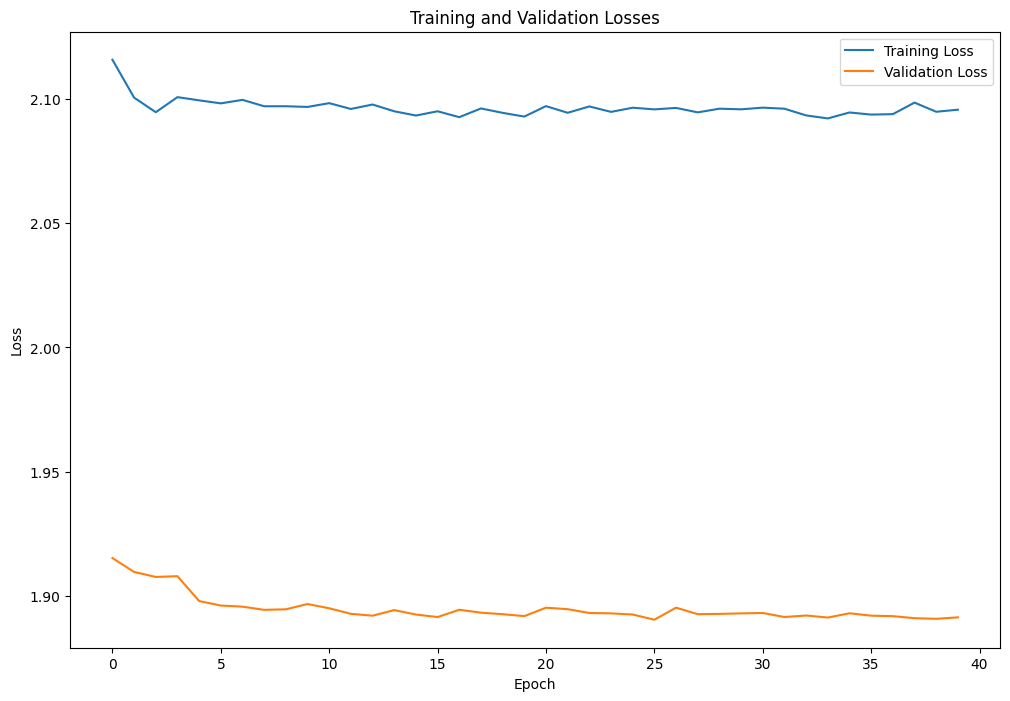

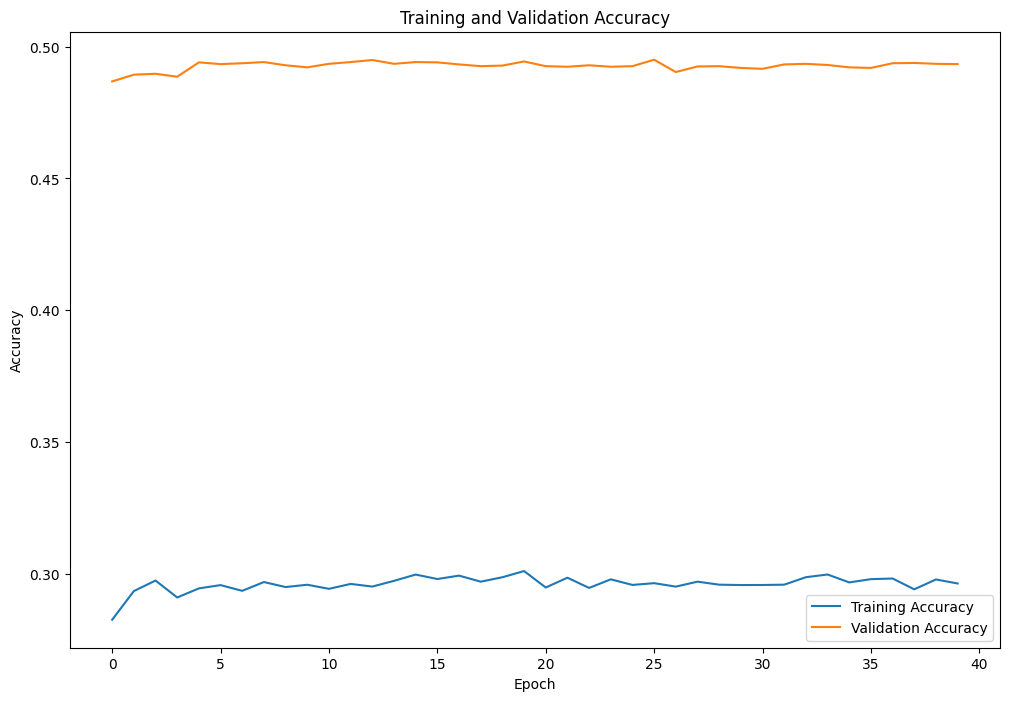

In [100]:
# Plot accuracy and loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [96]:
# visualize_feature_maps(model, 'conv1', test_dataset[1][0])
# visualize_feature_maps(model, 'pool1', test_dataset[1][0])
# visualize_feature_maps(model, 'conv2', test_dataset[1][0])

> Explanation about Feature Maps

As we can see from the above feature maps for different layers that they are able to capture different features of the image. The first layer is able to capture the edges of the image, the second layer is able to capture the shape of the image more effectively (We can see that it has features captured almost spatially invariant, so as to prevent over generalization, which layers 1 is doing more than this one). This is because the first layer is able to capture the low level features, and the second layer is able to capture the high level features.

#### 4.3

In [97]:
if hyperparameter_tuning:
    for model_name in ["Net1", "Net2", "Net3"]:
        for lr in [0.001, 0.01, 0.1]:
            for batch_size in [16, 32, 64]:
                train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
                val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
                test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
                test_loader1 = Data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

                for dropout in [0, 0.5]:
                    print(f"Model: {model_name}, lr: {lr}, batch_size: {batch_size}, dropout: {dropout}")
                    if model_name == "Net1":
                        model = Net1(dropout=dropout)
                    elif model_name == "Net2":
                        model = Net2(dropout=dropout)
                    elif model_name == "Net3":
                        model = Net3(dropout=dropout)
                    else: 
                        raise ValueError("Model name not found.")
                    model.to(device)

                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    wandb_init(lr, max_epochs, model_name, batch_size, dropout)
                    train_losses, val_losses, train_acc, val_acc = train(model, max_epochs, graph=False, wandb_log=wandb_log, print_every=None)
                    
                    test1 = test(model, test_loader, print_acc=False)
                    test2 = test(model, test_loader1, print_acc=False)
                    if wandb_log:
                        wandb.log({"test_acc": test1, "test_acc1": test2})
                    
                    wandb_finish()

In [118]:
wandb_data = pd.read_csv("../wandb_export_P4.csv")

wandb_data.sort_values(by=["val_acc"], ascending=False, inplace=True)
wandb_data.reset_index(drop=True, inplace=True)

print(wandb_data.head())

                      Name architecture  batch_size  dropout     lr  \
0  P4_Net3_0.001_32_20_0.5         Net3          32      0.5  0.001   
1  P4_Net2_0.001_32_20_0.5         Net2          32      0.5  0.001   
2  P4_Net2_0.001_64_20_0.5         Net2          64      0.5  0.001   
3    P4_Net2_0.001_64_20_0         Net2          64      0.0  0.001   
4  P4_Net3_0.001_16_20_0.5         Net3          16      0.5  0.001   

   num_epochs  epoch   test_acc  test_acc1  train_acc  train_loss   val_acc  \
0          20     20  99.233333      99.14   0.995810    0.012467  0.991889   
1          20     20  99.322222      99.31   0.995905    0.013096  0.991556   
2          20     20  99.144444      99.23   0.995214    0.014062  0.991222   
3          20     20  99.133333      99.15   0.998452    0.006092  0.991222   
4          20     20  99.088889      99.17   0.995929    0.013526  0.990444   

   val_loss  
0  0.045241  
1  0.040193  
2  0.038696  
3  0.047795  
4  0.050320  


In [119]:
print("Best Parameters")
print(wandb_data.iloc[0])

Best Parameters
Name            P4_Net3_0.001_32_20_0.5
architecture                       Net3
batch_size                           32
dropout                             0.5
lr                                0.001
num_epochs                           20
epoch                                20
test_acc                      99.233333
test_acc1                         99.14
train_acc                       0.99581
train_loss                     0.012467
val_acc                        0.991889
val_loss                       0.045241
Name: 0, dtype: object


In [122]:
# Comapre effect of using dropout or not

print("Without Dropout - Best Model")
result = wandb_data[(wandb_data["dropout"] == 0) & (wandb_data["architecture"] == "Net3") & (wandb_data["batch_size"] == 32) & (wandb_data["lr"] == 0.001)].iloc[0]
print(result)

Without Dropout - Best Model
Name            P4_Net3_0.001_32_20_0
architecture                     Net3
batch_size                         32
dropout                           0.0
lr                              0.001
num_epochs                         20
epoch                              20
test_acc                    99.044444
test_acc1                       98.98
train_acc                    0.998738
train_loss                   0.004657
val_acc                      0.989222
val_loss                     0.060553
Name: 8, dtype: object


We can see that without using dropout, the accuracy of the model id decreased. This is due to the reason of over-generalization of the model.

#### 4.4

> Best Model

In [120]:
model = Net3(dropout = 0.5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32

In [132]:
train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
test_loader1 = Data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [133]:
train_losses, val_losses, train_acc, val_acc = train(model, 20, graph=False)

Epoch 1, Batch 100, Loss: 1.456
Epoch 1, Batch 200, Loss: 0.588
Epoch 1, Batch 300, Loss: 0.436
Epoch 1, Batch 400, Loss: 0.328
Epoch 1, Batch 500, Loss: 0.289
Epoch 1, Batch 600, Loss: 0.261
Epoch 1, Batch 700, Loss: 0.257
Epoch 1, Batch 800, Loss: 0.252
Epoch 1, Batch 900, Loss: 0.234
Epoch 1, Batch 1000, Loss: 0.203
Epoch 1, Batch 1100, Loss: 0.201
Epoch 1, Batch 1200, Loss: 0.208
Epoch 1, Batch 1300, Loss: 0.206
Epoch 1, Train Loss: 0.376, Val Loss: 0.105, Accuracy: 0.968
Epoch 2, Batch 100, Loss: 0.176
Epoch 2, Batch 200, Loss: 0.172
Epoch 2, Batch 300, Loss: 0.164
Epoch 2, Batch 400, Loss: 0.178
Epoch 2, Batch 500, Loss: 0.155
Epoch 2, Batch 600, Loss: 0.167
Epoch 2, Batch 700, Loss: 0.147
Epoch 2, Batch 800, Loss: 0.145
Epoch 2, Batch 900, Loss: 0.126
Epoch 2, Batch 1000, Loss: 0.161
Epoch 2, Batch 1100, Loss: 0.155
Epoch 2, Batch 1200, Loss: 0.153
Epoch 2, Batch 1300, Loss: 0.131
Epoch 2, Train Loss: 0.156, Val Loss: 0.088, Accuracy: 0.974
Epoch 3, Batch 100, Loss: 0.120
Epoch 

KeyboardInterrupt: 

Accuracy on the test dataset: 99.04%
Accuracy for class 0: 99.08%
Accuracy for class 1: 99.71%
Accuracy for class 2: 99.67%
Accuracy for class 3: 99.58%
Accuracy for class 4: 99.24%
Accuracy for class 5: 98.74%
Accuracy for class 6: 99.19%
Accuracy for class 7: 99.45%
Accuracy for class 8: 98.40%
Accuracy for class 9: 97.21%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       866
           1       0.99      1.00      1.00      1024
           2       0.99      1.00      1.00       917
           3       0.99      1.00      0.99       944
           4       0.99      0.99      0.99       918
           5       0.99      0.99      0.99       793
           6       0.99      0.99      0.99       860
           7       0.99      0.99      0.99       908
           8       0.99      0.98      0.99       874
           9       0.99      0.97      0.98       896

    accuracy                           0.99      9000
   macro avg       0.99

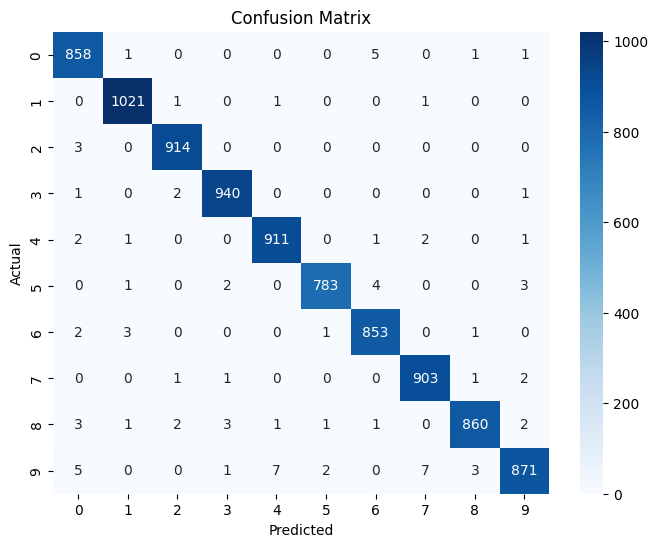

In [181]:
acc = test(model, test_loader, print_acc=True, per_class=True, classification=True, confusion=True)

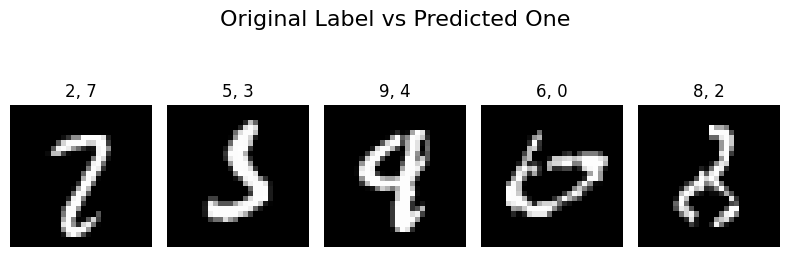

In [194]:
acc, misclassified = test(model, test_loader1, misclassified=True, print_acc=False)

# Plot the misclassified examples and their labels
plt.figure(figsize=(8, 20))
for i, (image, label, prediction) in enumerate(misclassified):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'{label}, {prediction}')
plt.tight_layout()
plt.suptitle('Original Label vs Predicted One', fontsize=16)
plt.show()

#### 4.5

In [173]:
class NoisyMNISTDataset(Data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)
    
    def add_noise(self, img):
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        return noisy_img

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = self.add_noise(image)
        return noisy_image, label

In [184]:
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset1 = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

train_set, val_set, test_set = Data.random_split(
    train_dataset, [
        int(train_ratio * dataset_size),
        int(val_ratio * dataset_size),
        int((1 - train_ratio - val_ratio) * dataset_size)
    ]
)

noisy_mnist_train_dataset = NoisyMNISTDataset(train_set)
train_loader = Data.DataLoader(noisy_mnist_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

noisy_mnist_val_dataset = NoisyMNISTDataset(val_set)
val_loader = Data.DataLoader(noisy_mnist_val_dataset, batch_size=batch_size, num_workers=num_workers)

noisy_mnist_test_dataset = NoisyMNISTDataset(test_set)
test_loader = Data.DataLoader(noisy_mnist_test_dataset, batch_size=batch_size, num_workers=num_workers)

noisy_mnist_test_dataset1 = NoisyMNISTDataset(test_dataset1)
test_loader1 = Data.DataLoader(noisy_mnist_test_dataset1, batch_size=batch_size, num_workers=num_workers)

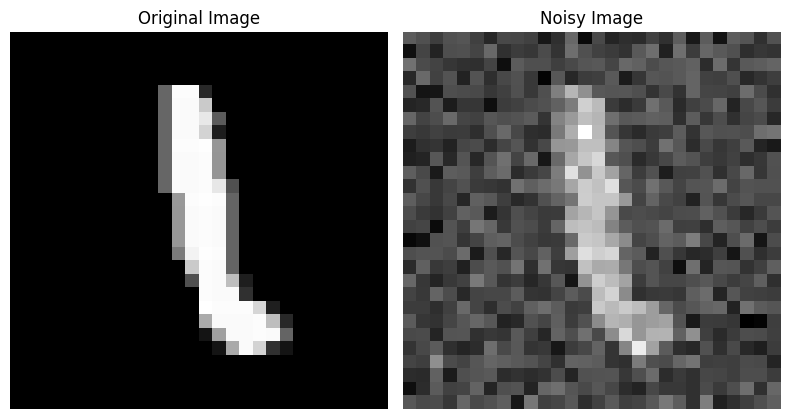

In [80]:
# Plot one noisy image

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(train_set[0][0].squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(noisy_mnist_train_dataset[0][0].squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [81]:
model = Net3(dropout = 0.5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32

In [82]:
train_losses, val_losses, train_acc, val_acc = train(model, 20, graph=False)

Epoch 1, Batch 100, Loss: 1.331
Epoch 1, Batch 200, Loss: 0.553
Epoch 1, Batch 300, Loss: 0.374
Epoch 1, Batch 400, Loss: 0.347
Epoch 1, Batch 500, Loss: 0.275
Epoch 1, Batch 600, Loss: 0.257
Epoch 1, Batch 700, Loss: 0.233
Epoch 1, Batch 800, Loss: 0.224
Epoch 1, Batch 900, Loss: 0.201
Epoch 1, Batch 1000, Loss: 0.182
Epoch 1, Batch 1100, Loss: 0.189
Epoch 1, Batch 1200, Loss: 0.183
Epoch 1, Batch 1300, Loss: 0.181
Epoch 1, Train Loss: 0.346, Val Loss: 0.104, Accuracy: 0.968
Epoch 2, Batch 100, Loss: 0.157
Epoch 2, Batch 200, Loss: 0.161
Epoch 2, Batch 300, Loss: 0.153
Epoch 2, Batch 400, Loss: 0.178
Epoch 2, Batch 500, Loss: 0.128
Epoch 2, Batch 600, Loss: 0.150
Epoch 2, Batch 700, Loss: 0.120
Epoch 2, Batch 800, Loss: 0.159
Epoch 2, Batch 900, Loss: 0.135
Epoch 2, Batch 1000, Loss: 0.154
Epoch 2, Batch 1100, Loss: 0.126
Epoch 2, Batch 1200, Loss: 0.136
Epoch 2, Batch 1300, Loss: 0.104
Epoch 2, Train Loss: 0.143, Val Loss: 0.089, Accuracy: 0.973
Epoch 3, Batch 100, Loss: 0.128
Epoch 

In [212]:
acc = test(model, test_loader, print_acc=True, classification=True)

Accuracy on the test dataset: 98.80%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       846
           1       0.99      0.99      0.99       972
           2       0.98      0.99      0.99       927
           3       0.99      0.99      0.99       917
           4       0.99      0.98      0.99       877
           5       1.00      0.98      0.99       755
           6       0.99      0.99      0.99       871
           7       0.99      0.99      0.99       985
           8       0.99      0.99      0.99       954
           9       0.98      0.98      0.98       896

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



We can see here that the overall accuracy of the model has dropped.

#### 4.6

In [130]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
        
#         self.encoder = torch.nn.Sequential(
#             torch.nn.Linear(28 * 28, 128),
#             torch.nn.ReLU(),
#             torch.nn.Linear(128, 64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(64, 36),
#             torch.nn.ReLU(),
#             torch.nn.Linear(36, 18)
#         )
        
#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(18, 36),
#             torch.nn.ReLU(),
#             torch.nn.Linear(36, 64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(64, 128),
#             torch.nn.ReLU(),
#             torch.nn.Linear(128, 28 * 28),
#             torch.nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [185]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [186]:
def train_autoencoder(model, train_loader, num_epochs, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    print("Training complete.")

In [187]:
encoder = Autoencoder()
encoder.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

train_autoencoder(encoder, train_loader, 10)

Epoch [1/10] Loss: 0.0750
Epoch [2/10] Loss: 0.0563
Epoch [3/10] Loss: 0.0523
Epoch [4/10] Loss: 0.0504
Epoch [5/10] Loss: 0.0492
Epoch [6/10] Loss: 0.0482
Epoch [7/10] Loss: 0.0475
Epoch [8/10] Loss: 0.0469
Epoch [9/10] Loss: 0.0464
Epoch [10/10] Loss: 0.0460
Training complete.


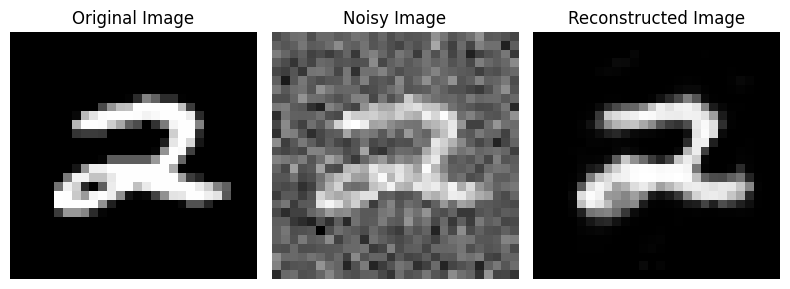

In [188]:
# Compare original and reconstructed images with the noisy ones

plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.imshow(train_set[1][0].squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(noisy_mnist_train_dataset[1][0].squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 3, 3)
reconstructed = encoder(noisy_mnist_train_dataset[1][0].view(1, -1).to(device)).reshape(28, 28).cpu().detach().numpy().squeeze()
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [189]:
class DeNoisyMNISTDataset(Data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        image = image.reshape(1, 28, 28)
        return image, label

In [190]:
denoised_train_set = DeNoisyMNISTDataset([(encoder(image.view(1, -1).to(device)).reshape(28, 28).cpu().detach().numpy(), label) for image, label in train_set])
train_loader = Data.DataLoader(denoised_train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

denoised_val_set = DeNoisyMNISTDataset([(encoder(image.view(1, -1).to(device)).reshape(28, 28).cpu().detach().numpy(), label) for image, label in val_set])
val_loader = Data.DataLoader(denoised_val_set, batch_size=batch_size, num_workers=num_workers)

denoised_test_set = DeNoisyMNISTDataset([(encoder(image.view(1, -1).to(device)).reshape(28, 28).cpu().detach().numpy(), label) for image, label in test_set])
test_loader = Data.DataLoader(denoised_test_set, batch_size=batch_size, num_workers=num_workers)

denoised_test_set1 = DeNoisyMNISTDataset([(encoder(image.view(1, -1).to(device)).reshape(28, 28).cpu().detach().numpy(), label) for image, label in test_dataset1])
test_loader1 = Data.DataLoader(denoised_test_set1, batch_size=batch_size, num_workers=num_workers)

In [191]:
model = Net3(dropout = 0.5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32

In [192]:
train_losses, val_losses, train_acc, val_acc = train(model, 20, graph=False)

Epoch 1, Batch 100, Loss: 1.239
Epoch 1, Batch 200, Loss: 0.476
Epoch 1, Batch 300, Loss: 0.331
Epoch 1, Batch 400, Loss: 0.284
Epoch 1, Batch 500, Loss: 0.275
Epoch 1, Batch 600, Loss: 0.213
Epoch 1, Batch 700, Loss: 0.226
Epoch 1, Batch 800, Loss: 0.207
Epoch 1, Batch 900, Loss: 0.186
Epoch 1, Batch 1000, Loss: 0.209
Epoch 1, Batch 1100, Loss: 0.154
Epoch 1, Batch 1200, Loss: 0.207
Epoch 1, Batch 1300, Loss: 0.163
Epoch 1, Train Loss: 0.319, Val Loss: 0.085, Accuracy: 0.973
Epoch 2, Batch 100, Loss: 0.163
Epoch 2, Batch 200, Loss: 0.163
Epoch 2, Batch 300, Loss: 0.149
Epoch 2, Batch 400, Loss: 0.152
Epoch 2, Batch 500, Loss: 0.150
Epoch 2, Batch 600, Loss: 0.135
Epoch 2, Batch 700, Loss: 0.127
Epoch 2, Batch 800, Loss: 0.132
Epoch 2, Batch 900, Loss: 0.135
Epoch 2, Batch 1000, Loss: 0.134
Epoch 2, Batch 1100, Loss: 0.119
Epoch 2, Batch 1200, Loss: 0.105
Epoch 2, Batch 1300, Loss: 0.130
Epoch 2, Train Loss: 0.138, Val Loss: 0.075, Accuracy: 0.976
Epoch 3, Batch 100, Loss: 0.106
Epoch 

In [193]:
test(model, test_loader, print_acc=True, classification=True)

Accuracy on the test dataset: 98.67%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       887
           1       0.99      1.00      0.99      1045
           2       0.99      0.99      0.99       889
           3       0.99      0.98      0.99       866
           4       0.99      0.98      0.98       883
           5       0.99      0.98      0.99       814
           6       0.99      0.99      0.99       925
           7       0.99      0.98      0.98       903
           8       0.98      0.98      0.98       880
           9       0.98      0.98      0.98       908

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



98.66666666666667